In [6]:
import os
import sys
from glob import glob
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras import applications as app
from keras import backend as k
import numpy as np
import PIL
import scipy
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [68]:
class NNModel:
    def __init__(self, name, weight_path, img_width, img_height):
        self.model_name = name
        self.model_weights_path = weight_path
        self.img_width, self.img_height = img_width, img_height
        self.model = None

        self.results_dir = os.path.join('results_RIMONE/', self.model_name)

        if not os.path.exists(self.results_dir):
            os.makedirs(self.results_dir)

    def load_json(self):
        with open(self.model_path, 'r') as model_json:
            loaded_model_json = model_json.read()
            self.model = model_from_json(loaded_model_json)

    def load_weights(self):
        if self.model:
            self.model.load_weights(self.model_weights_path)

    def classify(self, images_dir, batch_size=8):

        # Read Data
        test_datagen = ImageDataGenerator(rescale=1. / 255)
        test_generator = test_datagen.flow_from_directory(images_dir,
                                                          target_size=(self.img_width, self.img_height),
                                                          batch_size=batch_size,
                                                          shuffle=False)

        # Calculate class posteriors probabilities
        y_probabilities = self.model.predict(
            test_generator,
            steps=np.math.ceil(test_generator.samples / float(test_generator.batch_size))
        )

        # Calculate class labels
        filenames = test_generator.filenames
        classification = test_generator.classes
        classification_label = test_generator.class_indices
        print(len(filenames))
        print(y_probabilities)
        return y_probabilities, filenames, classification, classification_label

    def write_results(self, preds, results_name, filenames, classification, label):
        sub_fn = os.path.join(self.results_dir, 'results_' + self.model_name + results_name)

        with open(sub_fn + '.csv', 'w') as f:
            print("Writing Predictions to CSV...")
            keys = list(label.keys())
            values = list(label.values())
            f.write(f'image_name,Class,{keys[0]},{keys[1]}\n')
            for i, image_name in enumerate(filenames):
                pred = ['%.5f' % p for p in preds[i, :]]
                f.write('%s,%s,%s\n' % (
                    os.path.basename(image_name), keys[0] if classification[i] == values[0] else keys[1],
                    ','.join(pred)))
            print("Done.")

    def read_results(self, results_name):
        sub_fn = os.path.join(self.results_dir, 'results_' + self.model_name + results_name + '.csv')
        df = pd.read_csv(sub_fn)
        df['y_true'] = np.array((df.iloc[:, 1]) == df.iloc[:, 3].name).astype(int)
        comparison = list(zip(list(df.iloc[:, 2]), list(df.iloc[:, 3])))
        df['y_pred'] = np.argmin(comparison, 1)
        df['y_prob'] = comparison
        return df

    def paths_to_dataset(self, im_paths):
        input = []
        for im_path in im_paths:
            im = tf.keras.utils.load_img(im_path, target_size=(self.img_width, self.img_height))
            arr = tf.keras.utils.img_to_array(im)
            input.append(arr)
        x = np.array(input)
        return x

    def write_examples(self, _im_paths, _y_true, _y_pred)->(list, int, int):
        sub_fn = os.path.join(self.results_dir, 'examples_' + str(_y_true) + '_' + str(_y_pred) + self.model_name+'.csv')
        pd.DataFrame(list(filter(None, _im_paths))).to_csv(sub_fn, header=False)


In [66]:
class Verify:
    @staticmethod
    def confusion(_y_pred, _y_true, **kwargs):
        return ConfusionMatrixDisplay.from_predictions(_y_true, _y_pred, **kwargs)

    @staticmethod
    def roc(_y_pred, _y_true, **kwargs):
        return RocCurveDisplay.from_predictions(_y_true, _y_pred, **kwargs)

    @staticmethod
    def report(_y_pred, _y_true):
        print(classification_report(_y_true, _y_pred))

    @staticmethod
    def certainty(_y_prob, _y_true, **kwargs):
        class_0_prob = np.array(_y_prob[_y_true == 0].to_list())[:, 0]
        class_1_prob = np.array(_y_prob[_y_true == 1].to_list())[:, 1]
        plt.hist((class_0_prob, class_1_prob), **kwargs)
        plt.legend()
        return class_0_prob, class_1_prob

    @staticmethod
    def n_examples(df, true_class, counterfactual, n=16):
        df['class_0'] = np.array(df['y_prob'].to_list())[:,0]
        df['class_1'] = np.array(df['y_prob'].to_list())[:,1]
        temp = df[df['y_true'] == true_class].sort_values(by='class_'+str(true_class))
        if counterfactual:
            return temp[:n]
        else:
            return temp[::-1][:n]

    @staticmethod
    def examples(df, class_prob, true_class, counterfactual, epsilon=0.0005)->(pd.DataFrame, np.ndarray, int, bool, float):
        if counterfactual:
            examples = df['image_name'][df['y_true'] == true_class][class_prob < epsilon]
        else:
            examples = df['image_name'][df['y_true'] == true_class][class_prob > 1 - epsilon]
        return examples

    @staticmethod
    def visualize_examples(image_dir, examples, limit=None, ncol = 4)->(list):
        paths = []
        fig = plt.figure(figsize=(16, 12))
        if not limit:
            nrows = np.ceil(len(examples)/ncol).astype(int)
        else:
            nrows = np.ceil(limit/ncol).astype(int)
        for iter, ex in enumerate(examples):
            if iter == limit:
                break
            try:
                im_path = glob(os.path.join(image_dir,'**',ex))[0]
                paths.append(im_path)
                im = mpimg.imread(im_path)
                fig.add_subplot(nrows, ncol, iter + 1)
                plt.imshow(im)
            except IndexError as ie:
                print(ie)
                print(f'Issue in finding {ex} in {image_dir}')
        plt.tight_layout()
        plt.show()
        return paths

In [26]:
from tensorflow.keras.models import load_model
new_model = load_model(weight_path)

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000001C9C6EC6710>.

In [1]:
from tensorflow.keras.applications import Xception, InceptionV3, ResNet50, VGG16, VGG19

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(2, activation='softmax'))

In [29]:
model.load_weights(weight_path)

ValueError: Layer count mismatch when loading weights from file. Model expected 2 layers, found 14 saved layers.

In [107]:
weight_path = 'D:\MasterThesis\RIM-ONE_DL_cnn_weights\partitioned_randomly\InceptionV3\inceptionv3_final_weights.h5'

In [25]:
os.path.exists(weight_path)

True

In [184]:
conv_base = VGG19(include_top=False)

80134624/80134624 [==============================] - 9s 0us/step


In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________


In [31]:
import h5py

In [108]:
h5 = h5py.File(weight_path,'r')

In [109]:
h5

<HDF5 file "inceptionv3_final_weights.h5" (mode r)>

In [110]:
h5.keys()

<KeysViewHDF5 ['activation_1000', 'activation_1001', 'activation_1002', 'activation_1003', 'activation_1004', 'activation_1005', 'activation_1006', 'activation_1007', 'activation_1008', 'activation_1009', 'activation_1010', 'activation_1011', 'activation_1012', 'activation_1013', 'activation_1014', 'activation_1015', 'activation_1016', 'activation_1017', 'activation_1018', 'activation_1019', 'activation_1020', 'activation_1021', 'activation_1022', 'activation_1023', 'activation_1024', 'activation_1025', 'activation_1026', 'activation_1027', 'activation_1028', 'activation_1029', 'activation_1030', 'activation_1031', 'activation_1032', 'activation_1033', 'activation_940', 'activation_941', 'activation_942', 'activation_943', 'activation_944', 'activation_945', 'activation_946', 'activation_947', 'activation_948', 'activation_949', 'activation_950', 'activation_951', 'activation_952', 'activation_953', 'activation_954', 'activation_955', 'activation_956', 'activation_957', 'activation_958

In [185]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [186]:
out = conv_base.get_layer('block5_pool').output

In [187]:
global_average_pooling2d_11 = layers.GlobalAveragePooling2D()(out)

In [188]:
input_12 = layers.Dense(2, activation='softmax')(global_average_pooling2d_11)

In [43]:
import tensorflow as tf

In [189]:
model = tf.keras.Model(conv_base.input, input_12)

In [174]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [117]:
model.load_weights(weight_path)

In [47]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [49]:
models_names = ['ResNet50', 'InceptionV3', 'Xception', 'VGG16', 'VGG19']

In [98]:
weight_path = 'D:\MasterThesis\RIM-ONE_DL_cnn_weights\partitioned_randomly'

In [99]:
image_path = 'D:/MasterThesis/Datasets/RIM-ONE_DL_images/RIM-ONE_DL_images/partitioned_randomly/all_data'

In [123]:
image_path2 = '../Datasets/ACRIMA'

In [100]:
resnet50 = NNModel(models_names[0],
                os.path.join(weight_path, models_names[0], models_names[0] + '_final_weights.h5'),
                224, 224)
inception_v3 = NNModel(models_names[1],
                os.path.join(weight_path, models_names[1], models_names[1] + '_final_weights.h5'),
                299, 299)
xception = NNModel(models_names[2],
                os.path.join(weight_path, models_names[2], models_names[2] + '_final_weights.h5'),
                299, 299)
vgg16 = NNModel(models_names[3],
                   os.path.join(weight_path, models_names[3], models_names[3] + '_final_weights.h5'),
                   224, 224)
vgg19 = NNModel(models_names[4],
                os.path.join(weight_path, models_names[4], models_names[4] + '_final_weights.h5'),
                224, 224)

## ResNet50

In [101]:
resnet50.model = model

In [102]:
resnet50.load_weights()

In [103]:
y_pred, filenames, classification, classification_label = resnet50.classify(image_path)
resnet50.write_results(y_pred, 'rimone', filenames, classification, classification_label)

Found 485 images belonging to 2 classes.
61/61 [==============================] - 72s 1s/step
485
[[1.00622364e-08 1.00000000e+00]
 [1.02386977e-09 1.00000000e+00]
 [4.31272724e-08 1.00000000e+00]
 [5.65698624e-01 4.34301376e-01]
 [7.27541263e-08 9.99999881e-01]
 [2.67899907e-07 9.99999762e-01]
 [1.09150648e-07 9.99999881e-01]
 [6.70823397e-11 1.00000000e+00]
 [4.52626248e-09 1.00000000e+00]
 [5.71688531e-07 9.99999404e-01]
 [7.20142361e-06 9.99992847e-01]
 [9.90697563e-01 9.30235814e-03]
 [2.73315903e-09 1.00000000e+00]
 [3.44426883e-11 1.00000000e+00]
 [5.29586899e-08 1.00000000e+00]
 [1.23638156e-05 9.99987602e-01]
 [3.29318567e-07 9.99999642e-01]
 [6.82136680e-10 1.00000000e+00]
 [2.10478291e-04 9.99789536e-01]
 [1.56998776e-05 9.99984264e-01]
 [9.32614430e-09 1.00000000e+00]
 [3.40349153e-08 1.00000000e+00]
 [1.43373455e-08 1.00000000e+00]
 [1.36631745e-04 9.99863386e-01]
 [9.97572243e-01 2.42770719e-03]
 [8.80649512e-11 1.00000000e+00]
 [4.27151203e-10 1.00000000e+00]
 [1.4399549

In [138]:
df = resnet50.read_results('rimone')

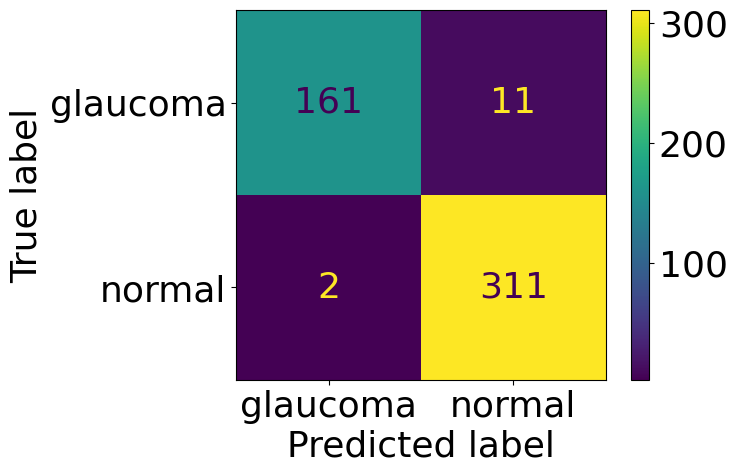

In [105]:
Verify.confusion(_y_pred=df['y_pred'],
                 _y_true=df['y_true'],
                 display_labels=labels
                 )

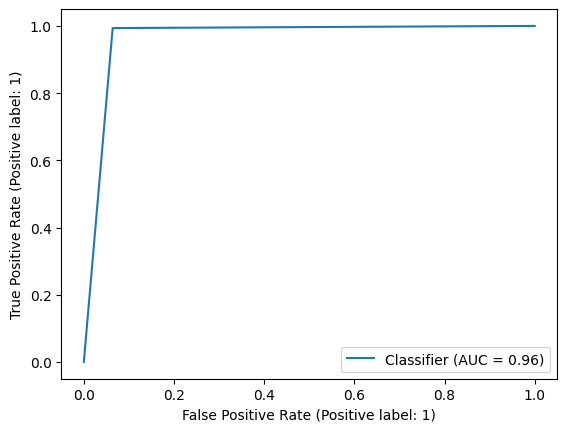

In [139]:
Verify.roc(_y_pred=df['y_pred'],
           _y_true=df['y_true'],
           pos_label=1)
plt.show()

In [141]:
y_pred, filenames, classification, classification_label = resnet50.classify(image_path2)
resnet50.write_results(y_pred, 'acrima', filenames, classification, classification_label)

Found 705 images belonging to 2 classes.
89/89 [==============================] - 65s 720ms/step
705
[[7.57156988e-04 9.99242902e-01]
 [4.01862770e-01 5.98137259e-01]
 [4.40923497e-04 9.99559104e-01]
 ...
 [1.58227719e-02 9.84177232e-01]
 [1.13511574e-04 9.99886513e-01]
 [5.14455792e-03 9.94855404e-01]]
Writing Predictions to CSV...
Done.


In [142]:
df = resnet50.read_results('acrima')

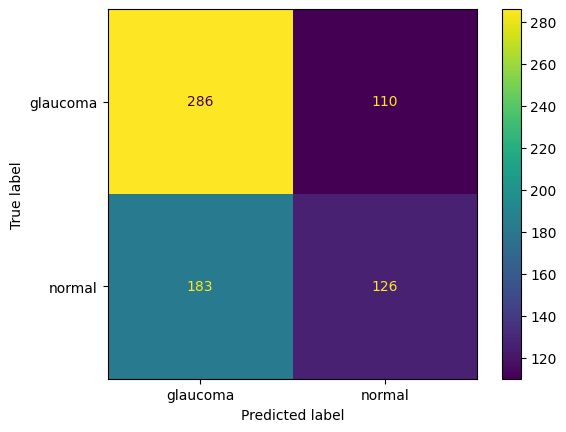

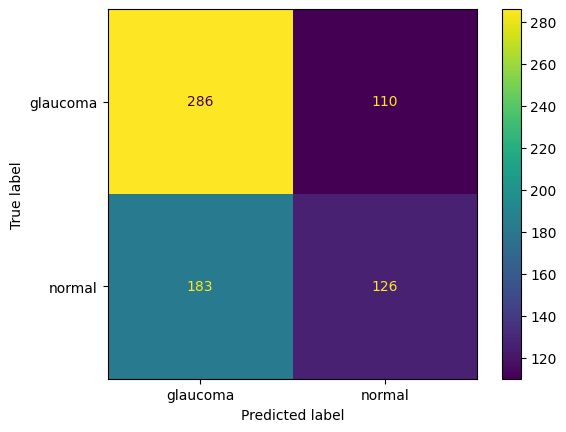

In [144]:
Verify.confusion(_y_pred=df['y_pred'],
                 _y_true=df['y_true'],
                 display_labels=labels
                 )
plt.show()

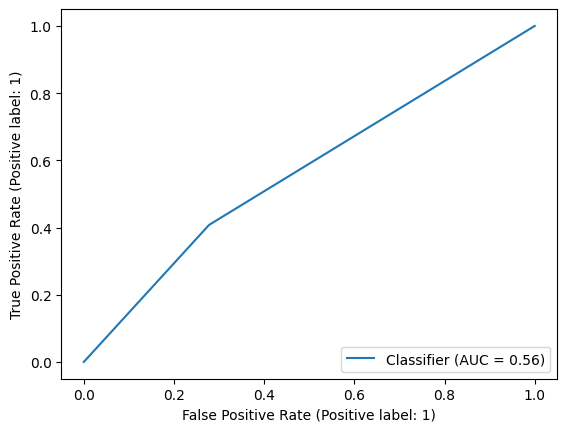

In [145]:
Verify.roc(_y_pred=df['y_pred'],
           _y_true=df['y_true'],
           pos_label=1)
plt.show()

## Inception V3

In [118]:
inception_v3.model = model

In [119]:
inception_v3.load_weights()

In [120]:
y_pred, filenames, classification, classification_label = inception_v3.classify(image_path)
inception_v3.write_results(y_pred, 'rimone', filenames, classification, classification_label)

Found 485 images belonging to 2 classes.
61/61 [==============================] - 49s 760ms/step
485
[[0.06700398 0.932996  ]
 [0.23138386 0.76861614]
 [0.13361304 0.86638695]
 [0.3230513  0.6769486 ]
 [0.14435029 0.85564965]
 [0.16490383 0.8350962 ]
 [0.0752145  0.9247855 ]
 [0.07248557 0.9275144 ]
 [0.16816404 0.8318359 ]
 [0.24424894 0.7557511 ]
 [0.17350943 0.8264905 ]
 [0.16322918 0.8367708 ]
 [0.0081979  0.99180216]
 [0.02573256 0.9742674 ]
 [0.01352775 0.98647225]
 [0.10055956 0.89944047]
 [0.112867   0.887133  ]
 [0.06580635 0.9341937 ]
 [0.1361895  0.8638105 ]
 [0.07730151 0.9226985 ]
 [0.05510606 0.94489396]
 [0.07404372 0.92595625]
 [0.03497299 0.965027  ]
 [0.02120136 0.9787987 ]
 [0.08196498 0.918035  ]
 [0.05876848 0.9412315 ]
 [0.10669755 0.8933025 ]
 [0.11100481 0.8889952 ]
 [0.10664172 0.89335823]
 [0.08418006 0.9158199 ]
 [0.0460085  0.9539915 ]
 [0.12952141 0.8704786 ]
 [0.2317977  0.7682023 ]
 [0.17730094 0.82269907]
 [0.01978768 0.98021233]
 [0.19491121 0.80508876]

In [136]:
df = inception_v3.read_results('rimone')

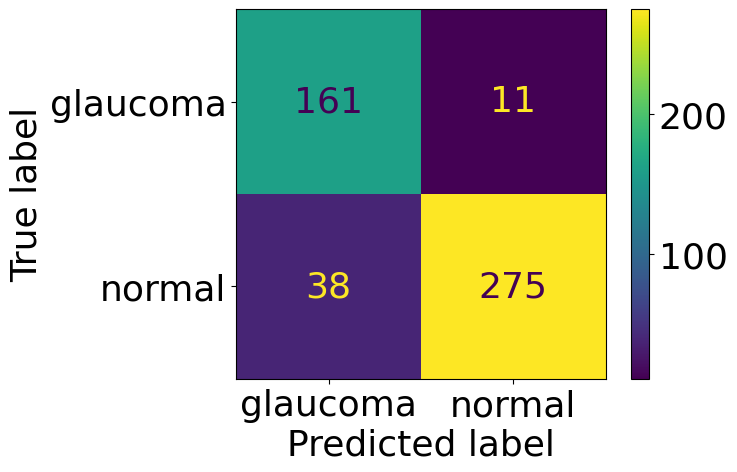

In [122]:
Verify.confusion(_y_pred=df['y_pred'],
                 _y_true=df['y_true'],
                 display_labels=labels
                 )

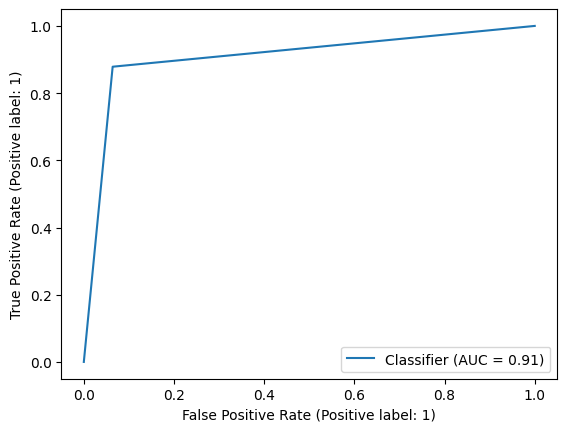

In [137]:
Verify.roc(_y_pred=df['y_pred'],
           _y_true=df['y_true'],
           pos_label=1)
plt.show()

In [124]:
y_pred, filenames, classification, classification_label = inception_v3.classify(image_path2)
inception_v3.write_results(y_pred, 'acrima', filenames, classification, classification_label)

Found 705 images belonging to 2 classes.
89/89 [==============================] - 83s 925ms/step
705
[[0.54461414 0.45538586]
 [0.13263269 0.8673673 ]
 [0.12718906 0.87281096]
 ...
 [0.42548326 0.5745168 ]
 [0.2502578  0.7497422 ]
 [0.17817922 0.82182074]]
Writing Predictions to CSV...
Done.


In [125]:
df = inception_v3.read_results('acrima')

In [127]:
df

,image_name,Class,Glaucoma,Healthy,y_true,y_pred,y_prob
0,Im310_g_ACRIMA.jpg,Glaucoma,0.54461,0.45539,0,1,"(0.54461, 0.45539)"
1,Im311_g_ACRIMA.jpg,Glaucoma,0.13263,0.86737,0,0,"(0.13263, 0.86737)"
2,Im312_g_ACRIMA.jpg,Glaucoma,0.12719,0.87281,0,0,"(0.12719, 0.87281)"
3,Im313_g_ACRIMA.jpg,Glaucoma,0.05922,0.94078,0,0,"(0.05922, 0.94078)"
4,Im314_g_ACRIMA.jpg,Glaucoma,0.11703,0.88297,0,0,"(0.11703, 0.88297)"
...,...,...,...,...,...,...,...
700,Im305_ACRIMA.jpg,Healthy,0.20992,0.79008,1,0,"(0.20992, 0.79008)"
701,Im306_ACRIMA.jpg,Healthy,0.28422,0.71578,1,0,"(0.28422, 0.71578)"
702,Im307_ACRIMA.jpg,Healthy,0.42548,0.57452,1,0,"(0.42548, 0.57452)"
703,Im308_ACRIMA.jpg,Healthy,0.25026,0.74974,1,0,"(0.25026, 0.74974)"


In [130]:
plt.rcParams.update(plt.rcParamsDefault)

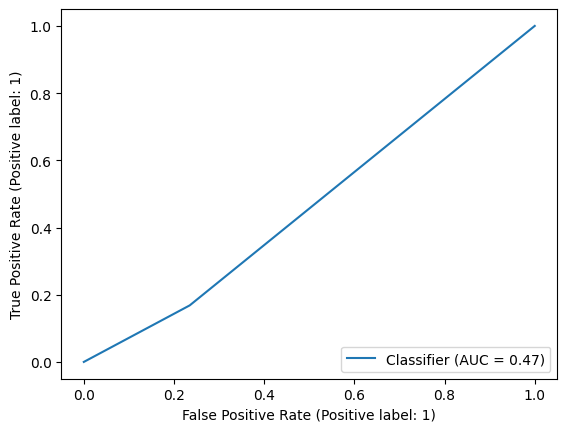

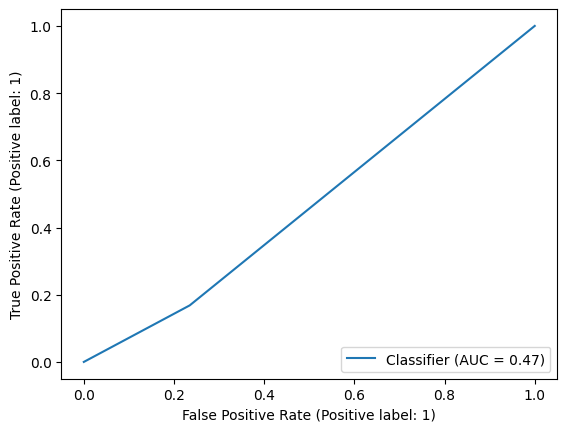

In [135]:
Verify.roc(_y_pred=df['y_pred'],
           _y_true=df['y_true'],
           pos_label=1)
plt.show()

## Xception

In [153]:
xception.model = model

In [154]:
xception.load_weights()

In [155]:
y_pred, filenames, classification, classification_label = xception.classify(image_path)
xception.write_results(y_pred, 'rimone', filenames, classification, classification_label)

Found 485 images belonging to 2 classes.
61/61 [==============================] - 134s 2s/step
485
[[1.82381589e-02 9.81761813e-01]
 [9.50737682e-04 9.99049246e-01]
 [3.59004945e-03 9.96409953e-01]
 [1.61054373e-01 8.38945627e-01]
 [3.25968079e-02 9.67403114e-01]
 [2.57322798e-03 9.97426808e-01]
 [3.30632343e-03 9.96693730e-01]
 [9.34888201e-04 9.99065101e-01]
 [2.47889832e-02 9.75211024e-01]
 [3.65725299e-03 9.96342719e-01]
 [1.93141364e-02 9.80685830e-01]
 [9.91898775e-02 9.00810122e-01]
 [4.38307296e-04 9.99561727e-01]
 [2.61577629e-02 9.73842263e-01]
 [3.94624434e-02 9.60537553e-01]
 [1.34979216e-02 9.86502111e-01]
 [4.77691321e-03 9.95223105e-01]
 [1.94051620e-02 9.80594814e-01]
 [1.21586752e-04 9.99878407e-01]
 [9.19613289e-04 9.99080420e-01]
 [4.82606664e-02 9.51739371e-01]
 [2.35673189e-02 9.76432621e-01]
 [2.09200531e-02 9.79079902e-01]
 [2.66295974e-03 9.97337043e-01]
 [1.21264309e-01 8.78735721e-01]
 [6.11703005e-03 9.93883014e-01]
 [9.06008482e-03 9.90939975e-01]
 [4.272482

In [156]:
df = xception.read_results('rimone')

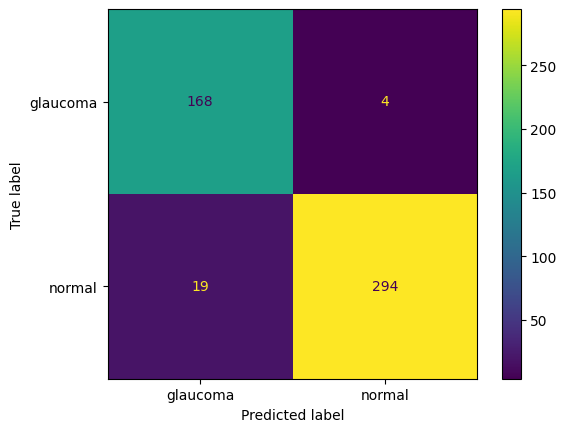

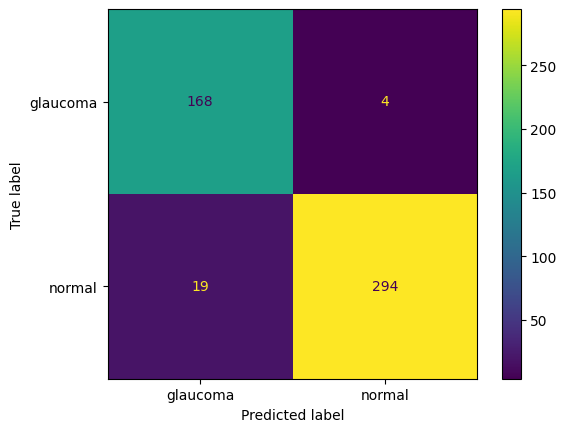

In [158]:
Verify.confusion(_y_pred=df['y_pred'],
                 _y_true=df['y_true'],
                 display_labels=labels
                 )
plt.show()

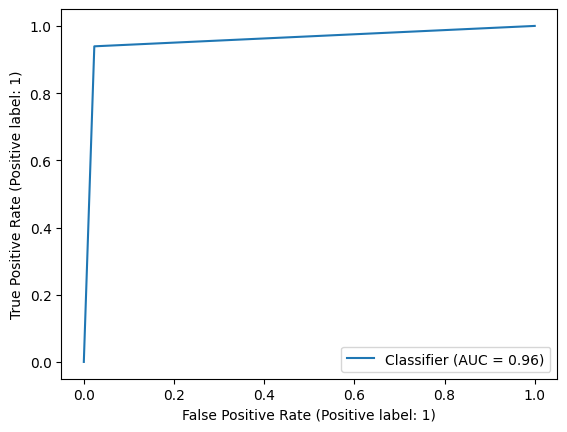

In [159]:
Verify.roc(_y_pred=df['y_pred'],
           _y_true=df['y_true'],
           pos_label=1)
plt.show()

In [160]:
y_pred, filenames, classification, classification_label = xception.classify(image_path2)
xception.write_results(y_pred, 'acrima', filenames, classification, classification_label)

Found 705 images belonging to 2 classes.
89/89 [==============================] - 188s 2s/step
705
[[0.23221223 0.76778775]
 [0.17468682 0.8253131 ]
 [0.00349412 0.99650586]
 ...
 [0.6155439  0.3844561 ]
 [0.01292211 0.98707783]
 [0.01075814 0.9892419 ]]
Writing Predictions to CSV...
Done.


In [161]:
df = xception.read_results('acrima')

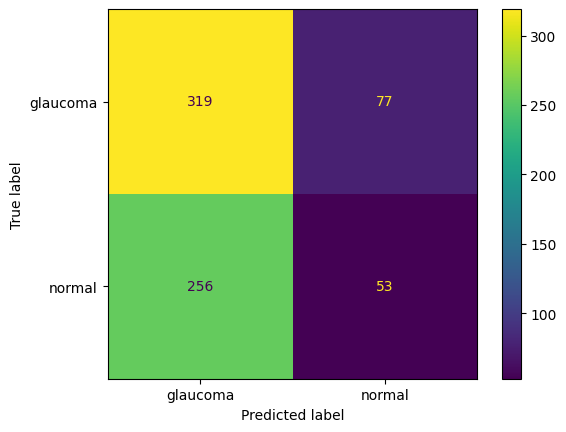

In [162]:
Verify.confusion(_y_pred=df['y_pred'],
                 _y_true=df['y_true'],
                 display_labels=labels
                 )
plt.show()

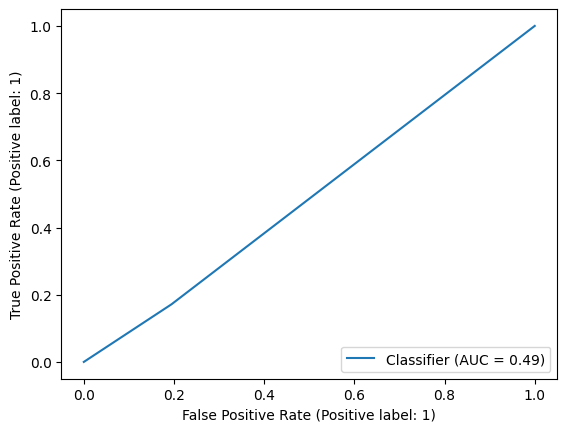

In [163]:
Verify.roc(_y_pred=df['y_pred'],
           _y_true=df['y_true'],
           pos_label=1)
plt.show()

##VGG 16

In [175]:
vgg16.model = model

In [176]:
vgg16.load_weights()

In [59]:
y_pred, filenames, classification, classification_label = vgg16.classify(image_path)
vgg16.write_results(y_pred, 'rimone', filenames, classification, classification_label)

Found 485 images belonging to 2 classes.
61/61 [==============================] - 157s 3s/step
485
[[1.35716272e-09 1.00000000e+00]
 [1.92273819e-06 9.99998093e-01]
 [2.47374533e-06 9.99997497e-01]
 [4.33302075e-02 9.56669807e-01]
 [1.36098281e-01 8.63901675e-01]
 [1.03195727e-01 8.96804333e-01]
 [2.19756574e-03 9.97802436e-01]
 [5.41879842e-03 9.94581163e-01]
 [3.83928636e-05 9.99961615e-01]
 [2.92925127e-02 9.70707536e-01]
 [5.02756059e-01 4.97243941e-01]
 [2.27618948e-01 7.72381008e-01]
 [2.35037623e-06 9.99997616e-01]
 [5.19123705e-06 9.99994755e-01]
 [3.33595723e-02 9.66640413e-01]
 [7.86436885e-06 9.99992132e-01]
 [2.15821838e-05 9.99978423e-01]
 [9.68009651e-01 3.19903828e-02]
 [1.59760330e-05 9.99984026e-01]
 [7.24371466e-06 9.99992728e-01]
 [8.88456952e-07 9.99999166e-01]
 [2.67761235e-09 1.00000000e+00]
 [8.58133435e-02 9.14186656e-01]
 [8.58667314e-01 1.41332716e-01]
 [9.99996543e-01 3.45701073e-06]
 [8.18479530e-05 9.99918103e-01]
 [6.57146447e-05 9.99934316e-01]
 [7.650272

In [165]:
df = vgg16.read_results('rimone')

In [71]:
df

,image_name,Class,glaucoma,normal,y_true,y_pred,y_prob
0,r1_Im069.png,glaucoma,0.00000,1.00000,0,0,"(0.0, 1.0)"
1,r1_Im103.png,glaucoma,0.00000,1.00000,0,0,"(0.0, 1.0)"
2,r1_Im113.png,glaucoma,0.00000,1.00000,0,0,"(0.0, 1.0)"
3,r1_Im117.png,glaucoma,0.04333,0.95667,0,0,"(0.04333, 0.95667)"
4,r1_Im118.png,glaucoma,0.13610,0.86390,0,0,"(0.1361, 0.8639)"
...,...,...,...,...,...,...,...
480,r3_N-88-R_left_half.png,normal,1.00000,0.00000,1,1,"(1.0, 0.0)"
481,r3_N-9-L_left_half.png,normal,1.00000,0.00000,1,1,"(1.0, 0.0)"
482,r3_N-90-R_left_half.png,normal,1.00000,0.00000,1,1,"(1.0, 0.0)"
483,r3_N-91-L_left_half.png,normal,1.00000,0.00000,1,1,"(1.0, 0.0)"


In [62]:
labels = list(df.columns[2:4])

In [63]:
plt.rcParams.update({'font.size': 26})

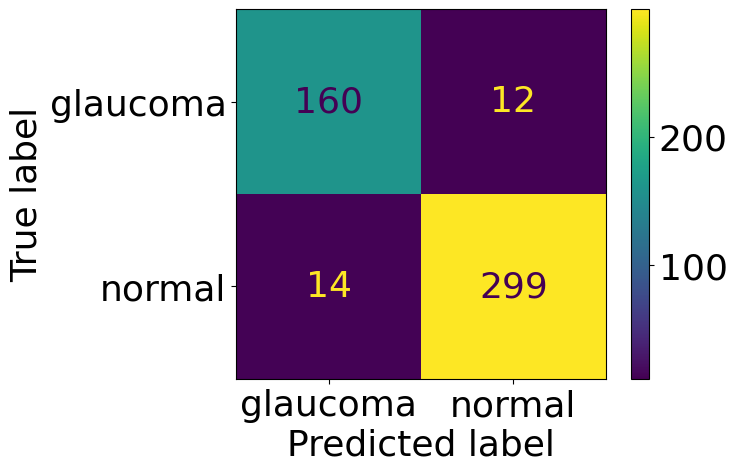

In [72]:
Verify.confusion(_y_pred=df['y_pred'],
                 _y_true=df['y_true'],
                 display_labels=labels
                 )

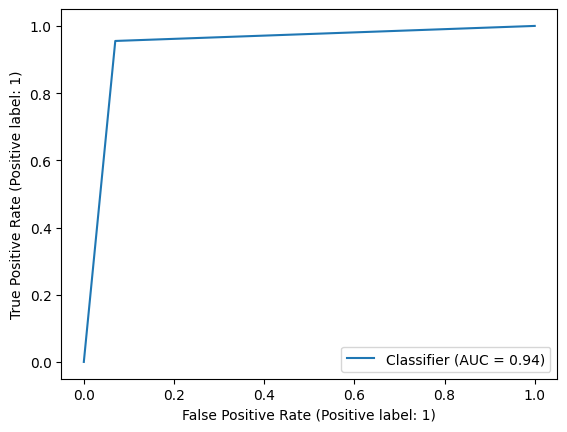

In [179]:
Verify.roc(_y_pred=df['y_pred'],
           _y_true=df['y_true'],
           pos_label=1)
plt.show()

In [177]:
y_pred, filenames, classification, classification_label = vgg16.classify(image_path2)
vgg16.write_results(y_pred, 'acrima', filenames, classification, classification_label)

Found 705 images belonging to 2 classes.
89/89 [==============================] - 152s 2s/step
705
[[8.2918064e-04 9.9917090e-01]
 [9.2112743e-05 9.9990785e-01]
 [6.8082181e-07 9.9999928e-01]
 ...
 [6.8472974e-02 9.3152708e-01]
 [5.5800186e-04 9.9944204e-01]
 [7.7581865e-01 2.2418135e-01]]
Writing Predictions to CSV...
Done.


In [180]:
df = vgg16.read_results('acrima')

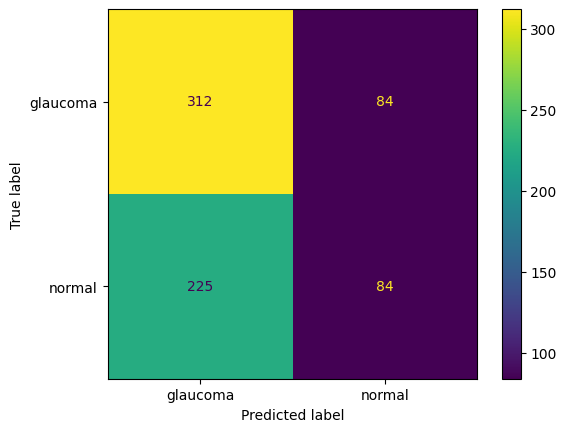

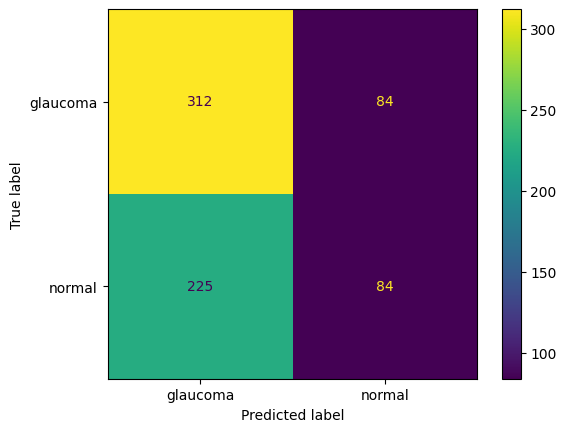

In [182]:
Verify.confusion(_y_pred=df['y_pred'],
                 _y_true=df['y_true'],
                 display_labels=labels
                 )
plt.show()

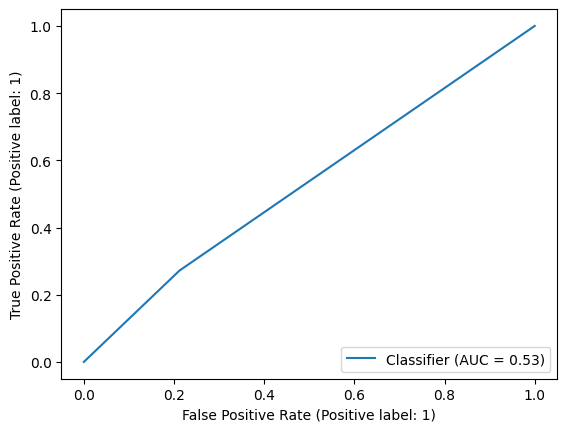

In [183]:
Verify.roc(_y_pred=df['y_pred'],
           _y_true=df['y_true'],
           pos_label=1)
plt.show()

## VGG 19

In [190]:
vgg19.model = model

In [191]:
vgg19.load_weights()

In [192]:
y_pred, filenames, classification, classification_label = vgg19.classify(image_path)
vgg19.write_results(y_pred, 'rimone', filenames, classification, classification_label)

Found 485 images belonging to 2 classes.
61/61 [==============================] - 110s 2s/step
485
[[4.20176775e-06 9.99995828e-01]
 [3.47216707e-03 9.96527851e-01]
 [7.45562829e-06 9.99992490e-01]
 [1.79818459e-02 9.82018113e-01]
 [5.14165498e-03 9.94858384e-01]
 [7.87910249e-04 9.99212027e-01]
 [6.00432802e-04 9.99399543e-01]
 [3.00150685e-04 9.99699831e-01]
 [7.17989460e-04 9.99282062e-01]
 [1.69317573e-04 9.99830604e-01]
 [1.33154754e-04 9.99866843e-01]
 [5.53010225e-01 4.46989805e-01]
 [1.86093928e-07 9.99999762e-01]
 [8.66531263e-05 9.99913335e-01]
 [1.13346301e-04 9.99886632e-01]
 [6.57199053e-05 9.99934316e-01]
 [2.96213202e-05 9.99970436e-01]
 [6.85733103e-04 9.99314308e-01]
 [4.59551375e-04 9.99540448e-01]
 [2.90215918e-04 9.99709785e-01]
 [1.11594010e-04 9.99888420e-01]
 [1.73176188e-04 9.99826849e-01]
 [1.59373845e-03 9.98406231e-01]
 [1.27946565e-04 9.99872088e-01]
 [9.98227417e-01 1.77258055e-03]
 [2.72018769e-05 9.99972820e-01]
 [5.33386412e-07 9.99999523e-01]
 [2.078977

In [194]:
df = vgg19.read_results('rimone')

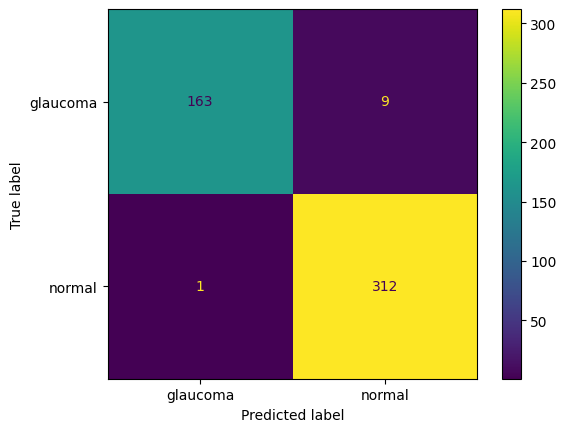

In [195]:
Verify.confusion(_y_pred=df['y_pred'],
                 _y_true=df['y_true'],
                 display_labels=labels
                 )
plt.show()

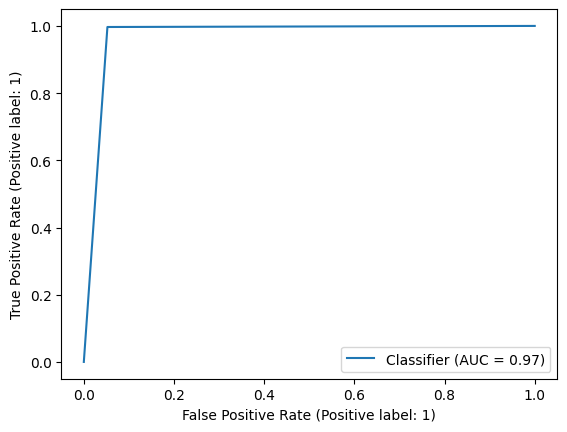

In [196]:
Verify.roc(_y_pred=df['y_pred'],
           _y_true=df['y_true'],
           pos_label=1)
plt.show()

In [197]:
y_pred, filenames, classification, classification_label = vgg19.classify(image_path2)
vgg19.write_results(y_pred, 'acrima', filenames, classification, classification_label)

Found 705 images belonging to 2 classes.
89/89 [==============================] - 165s 2s/step
705
[[1.4596219e-04 9.9985397e-01]
 [4.4995097e-05 9.9995506e-01]
 [6.6666216e-05 9.9993336e-01]
 ...
 [9.7910482e-01 2.0895157e-02]
 [9.7056490e-04 9.9902940e-01]
 [9.8324943e-01 1.6750585e-02]]
Writing Predictions to CSV...
Done.


In [198]:
df = vgg19.read_results('acrima')

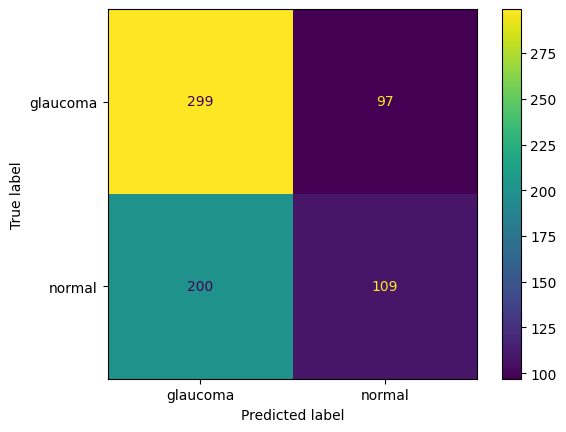

In [199]:
Verify.confusion(_y_pred=df['y_pred'],
                 _y_true=df['y_true'],
                 display_labels=labels
                 )
plt.show()

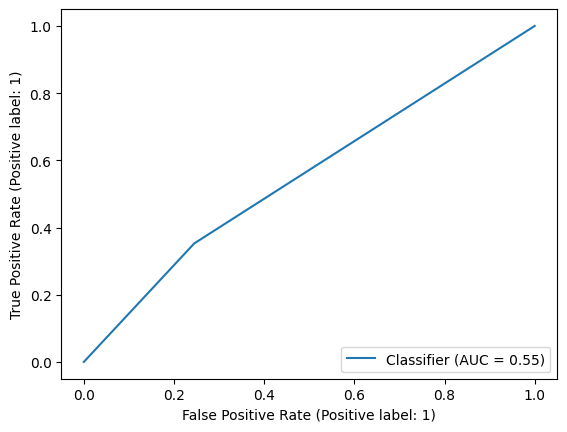

In [200]:
Verify.roc(_y_pred=df['y_pred'],
           _y_true=df['y_true'],
           pos_label=1)
plt.show()